In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense


In [3]:
# Download historical stock data (SBIN.NS = State Bank of India)
START = "2015-01-01"
TODAY = pd.Timestamp.today().strftime('%Y-%m-%d')

df = yf.download('SBIN.NS', start=START, end=TODAY)
df = df[['Close']]
df.tail()


[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,SBIN.NS
Date,
2025-04-11,753.849976
2025-04-15,763.500000
2025-04-16,771.750000
2025-04-17,797.450012
2025-04-21,816.700012


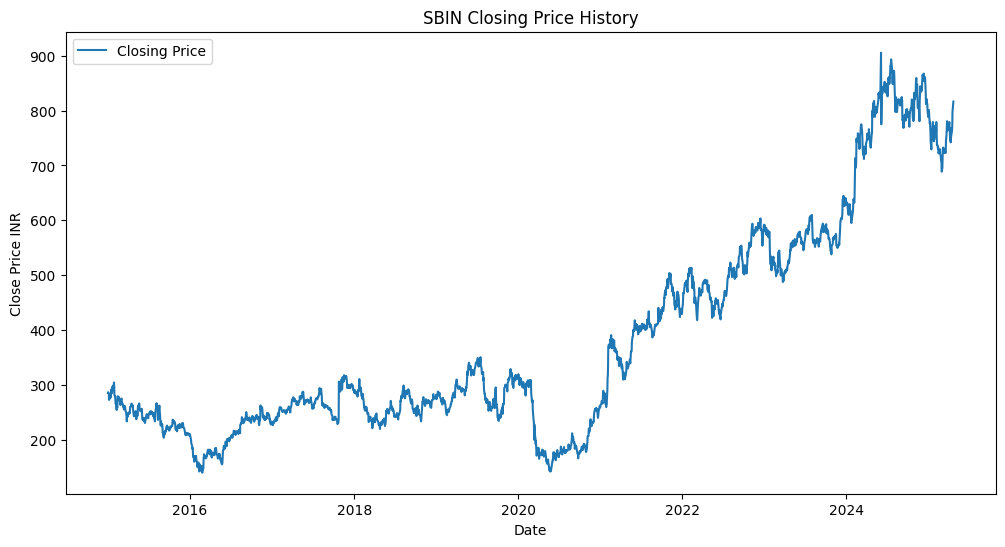

In [4]:
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Closing Price')
plt.title('SBIN Closing Price History')
plt.xlabel('Date')
plt.ylabel('Close Price INR')
plt.legend()
plt.show()


In [5]:
dataset = df.values
training_data_len = int(np.ceil(len(dataset) * 0.7))

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)


In [6]:
train_data = scaled_data[0:training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape to 3D for LSTM input
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))


In [7]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80))
model.add(Dropout(0.4))

model.add(Dense(units=1))  # Output layer


C:\Users\kedar\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=64, epochs=50)


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0131
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0017
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0011
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0012
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 9.4889e-04
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0010
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 8.8115e-04
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 8.1489e-04
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 8.3385e-04
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 8.7057e-04
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 7.7044e-04
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 7.0236e-04
Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 7.7020e-04
Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 8.0642e-04
Epoch 15/50
27/27 ━━━━━━━━━━━━━━━━━

In [9]:
test_data = scaled_data[training_data_len - 60:, :]

x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))


In [10]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [11]:
rmse = math.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f"✅ Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"✅ R² Score: {r2:.4f}")


✅ Root Mean Squared Error (RMSE): 16.34
✅ R² Score: 0.9845


C:\Users\kedar\AppData\Local\Temp\ipykernel_11728\2629693807.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


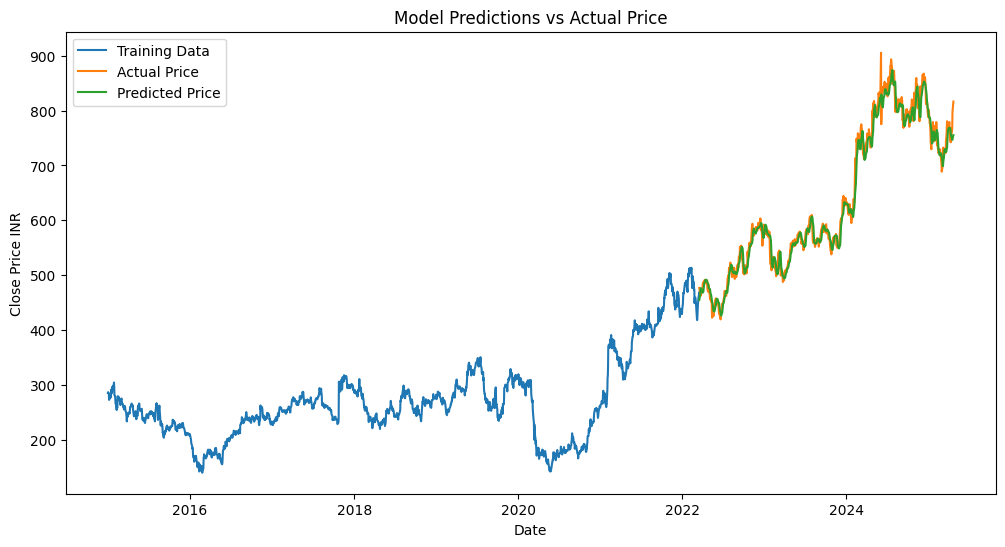

In [12]:
train = df[:training_data_len]
valid = df[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(12,6))
plt.title('Model Predictions vs Actual Price')
plt.plot(train['Close'], label='Training Data')
plt.plot(valid['Close'], label='Actual Price')
plt.plot(valid['Predictions'], label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Close Price INR')
plt.legend()
plt.show()


In [13]:
latest_data = scaled_data[-60:]
latest_data = np.reshape(latest_data, (1, 60, 1))

predicted_price = model.predict(latest_data)
predicted_price = scaler.inverse_transform(predicted_price)

print(f"📈 Predicted Closing Price for Next Trading Day: ₹{predicted_price[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
📈 Predicted Closing Price for Next Trading Day: ₹768.42
